Sumber Data : https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231?select=AABA_2006-01-01_to_2018-01-01.csv

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.683146898000004
GPU (s):
0.045938444999990224
GPU speedup over CPU: 80x


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
df = pd.read_csv('AABA_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])

In [ ]:
df.head(6)

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA
5,2006-01-10,42.96,43.34,42.34,42.98,16288580,AABA


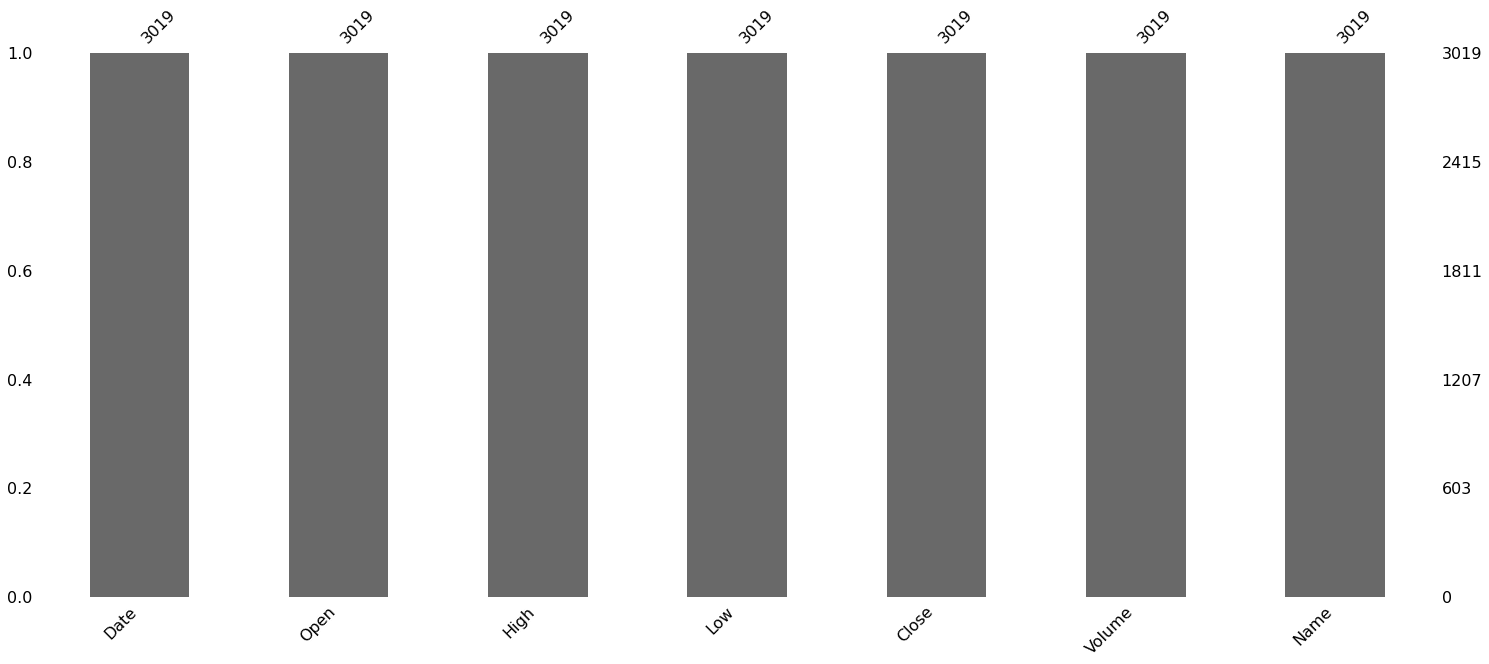

In [ ]:
import missingno as mons

mons.bar(df)

In [ ]:
df.shape

(3019, 7)

In [ ]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [ ]:
df.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,28.426479,28.766532,28.066558,28.412726,2.158391e+07
std,13.257242,13.356692,13.157326,13.258163,1.926231e+07
min,9.100000,9.480000,8.940000,8.950000,1.939061e+06
25%,16.175000,16.385000,15.970000,16.130000,1.248025e+07
50%,27.180000,27.490000,26.820000,27.100000,1.732130e+07
75%,36.655000,37.035000,36.305000,36.635000,2.512757e+07
max,73.020000,73.250000,72.460000,72.930000,4.382317e+08


In [ ]:
df = df.drop(['Close', 'High', 'Low', 'Volume', 'Name'], axis='columns')

In [ ]:
df

,Date,Open
0,2006-01-03,39.69
1,2006-01-04,41.22
2,2006-01-05,40.93
3,2006-01-06,42.88
4,2006-01-09,43.10
...,...,...
3014,2017-12-22,71.42
3015,2017-12-26,70.94
3016,2017-12-27,69.77
3017,2017-12-28,70.12


Text(0.5, 1.0, 'AABA Open Value')

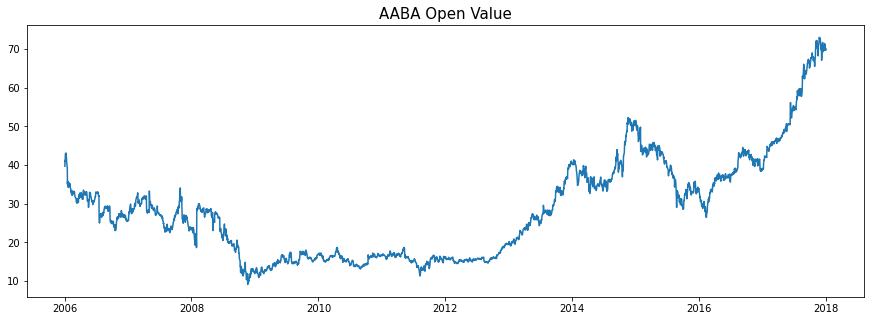

In [ ]:
dates = df['Date'].values
open = df['Open'].values

plt.figure(figsize=(15,5))
plt.plot(dates, open)
plt.title('AABA Open Value',fontsize=15)

In [ ]:
print("MAE harus dibawah "+str(df['Open'].max()-df['Open'].min()))

MAE harus dibawah 63.919999999999995


In [ ]:
def windowed_dataset(series, shuffle_buffer, window_size = 40, batch_size = 100):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(dates, open, test_size=0.2, shuffle=False)

train_set = windowed_dataset(train_y, shuffle_buffer=1000)
val_set = windowed_dataset(val_y, shuffle_buffer=1000)

In [ ]:
from keras.layers import Dense, LSTM, Dropout, Bidirectional 
from keras.models import Sequential

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(120, activation="relu"),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')<10) and (logs.get('val_mae')<10):
      print('\nMAE sudah <10%!')
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
from tensorflow.keras.optimizers import SGD

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-03, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=callbacks)

Epoch 1/100
24/24 [==============================] - 7s 77ms/step - loss: 23.3583 - mae: 23.8583 - val_loss: 44.1517 - val_mae: 44.6517
Epoch 2/100
24/24 [==============================] - 1s 37ms/step - loss: 21.3880 - mae: 21.8880 - val_loss: 39.0766 - val_mae: 39.5766
Epoch 3/100
24/24 [==============================] - 1s 36ms/step - loss: 9.2662 - mae: 9.7596 - val_loss: 17.0643 - val_mae: 17.5621
Epoch 4/100
24/24 [==============================] - 1s 38ms/step - loss: 7.9750 - mae: 8.4571 - val_loss: 12.7192 - val_mae: 13.2072
Epoch 5/100
24/24 [==============================] - 1s 44ms/step - loss: 8.0422 - mae: 8.5246 - val_loss: 11.7715 - val_mae: 12.2565
Epoch 6/100
24/24 [==============================] - 1s 38ms/step - loss: 7.2283 - mae: 7.7132 - val_loss: 13.0563 - val_mae: 13.5493
Epoch 7/100
24/24 [==============================] - 1s 36ms/step - loss: 6.3463 - mae: 6.8280 - val_loss: 13.8422 - val_mae: 14.3367
Epoch 8/100
24/24 [==============================] - 1s 36

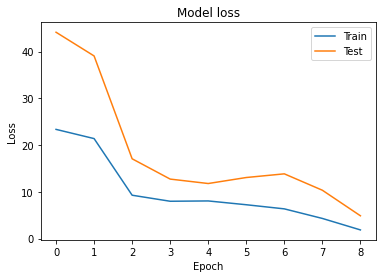

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper right')
plt.show()

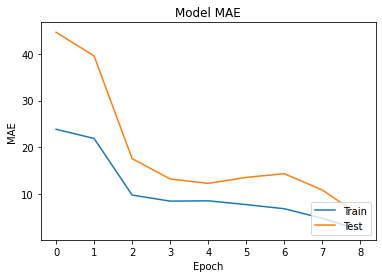

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='lower right')
plt.show()